In [1]:
import zipfile
import os
import seaborn as sns
import numpy as np
import pandas as pd
from glob import glob
import shutil, sys 
import os
import cv2
from matplotlib import pyplot as plt
import PIL.Image
from IPython.display import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets
import time
from tqdm import tqdm
import random
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
filepath = '/content/drive/MyDrive/523_DeepLearning/FinalProject/Data/'

In [4]:
dataList = pd.read_csv(filepath+'driver_imgs_list.csv') 

In [5]:
dataList

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg
...,...,...,...
22419,p081,c9,img_56936.jpg
22420,p081,c9,img_46218.jpg
22421,p081,c9,img_25946.jpg
22422,p081,c9,img_67850.jpg


In [6]:
print('Number of images in training set = ',str(len(glob(filepath+'train/*/*.jpg'))))
print('Number of images in testing set = ',str(len(glob(filepath+'TestData/*/*.jpg'))))


Number of images in training set =  20405
Number of images in testing set =  2019


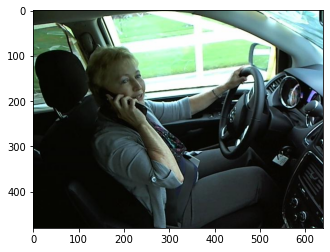

In [7]:
img = cv2.imread(filepath+"train/c2/img_258.jpg")
img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_cvt)
plt.show()

In [8]:
classes = [c for c in os.listdir(filepath+"train") if not c.startswith(".")]
classes.sort()
print(classes)

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


In [9]:
class_dict = {0 : "safe driving",
              1 : "texting - right",
              2 : "talking on the phone - right",
              3 : "texting - left",
              4 : "talking on the phone - left",
              5 : "operating the radio",
              6 : "drinking",
              7 : "reaching behind",
              8 : "hair and makeup",
              9 : "talking to passenger"}

Total number of training data : 20405


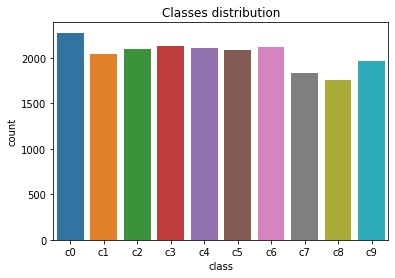

In [10]:
d = {"img" : [], "class" : []}
for c in classes:
    imgs = [img for img in os.listdir(os.path.join(filepath+"train",c)) if not img.startswith(".")]
    for img in imgs:
        d["img"].append(img)
        d["class"].append(c)
df = pd.DataFrame(d)
ax = sns.countplot(data=df,x="class")
ax.set(title="Classes distribution")
print("Total number of training data :",len(df))

AlexNet Model

In [11]:
transform = transforms.Compose([transforms.Resize((400, 400)),
                                 transforms.RandomRotation(10),
                                 transforms.ToTensor()])

In [12]:
data = datasets.ImageFolder(root = filepath+"train", transform = transform)

total_len = len(data)
training_len = int(0.9*total_len)
val_len = total_len - training_len

training_data,val_data = torch.utils.data.random_split(data,(training_len,val_len))

In [13]:
train_loader = torch.utils.data.DataLoader(dataset=training_data,
                                           batch_size=32,
                                           shuffle=True,
                                           drop_last=False,
                                           num_workers=2)
val_loader = torch.utils.data.DataLoader(dataset=val_data,
                                          batch_size=32,
                                          shuffle=False,
                                          drop_last=False,
                                          num_workers=2)

In [14]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [15]:
model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [16]:
model_ft

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [17]:
#num_ftrs = model_ft.fc.in_features
num_ftrs = model_ft.classifier[6].in_features
model_ft.fc = nn.Linear(num_ftrs, 10)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
# optimize parameters here
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
#optimizer_ft = torch.optim.Adam(model_ft.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=6, gamma=0.1)

In [18]:
model_ft

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [19]:
def eval_model(model,test_loader):
    correct = 0.0
    total = 0.0
    running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc

In [21]:
def train_model(model, criterion, optimizer, scheduler, n_epochs = 1):
    
    losses = []
    train_accuracies = []
    val_accuracies = []
    # set the model to train mode initially
    model.train()
    for epoch in tqdm(range(n_epochs)):
        print("\nStarting epoch ", epoch+1)
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for data in train_loader:

            # get the inputs and assign them to cuda
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # calculate the loss/acc later
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100/32*running_correct/len(train_loader)

        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        val_acc = eval_model(model,val_loader)
        val_accuracies.append(val_acc)
        if (epoch+1) % 2 == 0:
          torch.save(model.state_dict(), filepath+'Models/model_alex_epoch{}.pth'.format(epoch+1)) 
        
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(val_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, train_accuracies, val_accuracies

In [ ]:
# takes around 6-7 minutes per epoch with GPU
model_ft, training_losses, training_accs, val_accs = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, n_epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]


Starting epoch  1
Epoch 1, duration: 156 s, loss: 0.1151, acc: 96.6627


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  5%|▌         | 1/20 [02:53<54:50, 173.19s/it]

Accuracy of the network on the test images: 98 %

Starting epoch  2
Epoch 2, duration: 157 s, loss: 0.0813, acc: 97.7842
Accuracy of the network on the test images: 98 %


 10%|█         | 2/20 [05:48<52:15, 174.21s/it]


Starting epoch  3
Epoch 3, duration: 156 s, loss: 0.0826, acc: 97.8114


 15%|█▌        | 3/20 [08:40<49:08, 173.44s/it]

Accuracy of the network on the test images: 98 %

Starting epoch  4
Epoch 4, duration: 155 s, loss: 0.0813, acc: 97.8441
Accuracy of the network on the test images: 98 %


 20%|██        | 4/20 [11:33<46:12, 173.31s/it]


Starting epoch  5
Epoch 5, duration: 155 s, loss: 0.0810, acc: 97.7025


 25%|██▌       | 5/20 [14:26<43:14, 172.97s/it]

Accuracy of the network on the test images: 98 %

Starting epoch  6
Epoch 6, duration: 155 s, loss: 0.0804, acc: 97.8005
Accuracy of the network on the test images: 98 %


 30%|███       | 6/20 [17:18<40:18, 172.74s/it]


Starting epoch  7
Epoch 7, duration: 153 s, loss: 0.0823, acc: 97.7406


 35%|███▌      | 7/20 [20:08<37:15, 171.98s/it]

Accuracy of the network on the test images: 98 %

Starting epoch  8
Epoch 8, duration: 154 s, loss: 0.0805, acc: 97.8005
Accuracy of the network on the test images: 98 %


 40%|████      | 8/20 [23:01<34:27, 172.26s/it]


Starting epoch  9
Epoch 9, duration: 154 s, loss: 0.0825, acc: 97.7461


 45%|████▌     | 9/20 [25:52<31:30, 171.90s/it]

Accuracy of the network on the test images: 98 %

Starting epoch  10
Epoch 10, duration: 156 s, loss: 0.0794, acc: 97.8604
Accuracy of the network on the test images: 98 %


 50%|█████     | 10/20 [28:47<28:47, 172.77s/it]


Starting epoch  11
Epoch 11, duration: 155 s, loss: 0.0807, acc: 97.7624


 55%|█████▌    | 11/20 [31:40<25:54, 172.74s/it]

Accuracy of the network on the test images: 98 %

Starting epoch  12
Epoch 12, duration: 154 s, loss: 0.0814, acc: 97.8223
Accuracy of the network on the test images: 98 %


 60%|██████    | 12/20 [34:32<23:00, 172.51s/it]


Starting epoch  13
Epoch 13, duration: 154 s, loss: 0.0835, acc: 97.7352


 65%|██████▌   | 13/20 [37:22<20:03, 171.99s/it]

Accuracy of the network on the test images: 98 %

Starting epoch  14
Epoch 14, duration: 154 s, loss: 0.0818, acc: 97.8277
Accuracy of the network on the test images: 98 %


 70%|███████   | 14/20 [40:14<17:10, 171.83s/it]


Starting epoch  15
Epoch 15, duration: 154 s, loss: 0.0799, acc: 97.8822


 75%|███████▌  | 15/20 [43:05<14:17, 171.48s/it]

Accuracy of the network on the test images: 98 %

Starting epoch  16
Epoch 16, duration: 153 s, loss: 0.0789, acc: 97.9911
Accuracy of the network on the test images: 98 %


 80%|████████  | 16/20 [45:55<11:24, 171.21s/it]


Starting epoch  17
Epoch 17, duration: 153 s, loss: 0.0828, acc: 97.6916


 85%|████████▌ | 17/20 [48:45<08:32, 170.85s/it]

Accuracy of the network on the test images: 98 %

Starting epoch  18
Epoch 18, duration: 153 s, loss: 0.0814, acc: 97.6807
Accuracy of the network on the test images: 98 %


 90%|█████████ | 18/20 [51:36<05:41, 170.85s/it]


Starting epoch  19
Epoch 19, duration: 154 s, loss: 0.0843, acc: 97.7352


 95%|█████████▌| 19/20 [54:27<02:50, 170.85s/it]

Accuracy of the network on the test images: 98 %

Starting epoch  20
Epoch 20, duration: 154 s, loss: 0.0787, acc: 97.9366
Accuracy of the network on the test images: 98 %


100%|██████████| 20/20 [57:19<00:00, 171.99s/it]

Finished Training


In [ ]:
training_losses

[0.11512732370359051,
 0.08129276992195003,
 0.08259910521201322,
 0.08129924190237157,
 0.08099482772719335,
 0.08038792565127491,
 0.08233499368214622,
 0.08047655722506032,
 0.08254772852148977,
 0.07940384678101291,
 0.08071409523217754,
 0.0813632189662874,
 0.08348647325757229,
 0.08180123258411287,
 0.07987714518844848,
 0.0789038508843293,
 0.08284123153880057,
 0.08144411429250126,
 0.08434430079109552,
 0.07872133304199483]

In [ ]:
training_accs

[96.66267421602788,
 97.78418989547038,
 97.81141114982579,
 97.84407665505226,
 97.70252613240419,
 97.80052264808363,
 97.74063588850174,
 97.80052264808363,
 97.74608013937282,
 97.8604094076655,
 97.76241289198606,
 97.82229965156795,
 97.73519163763066,
 97.82774390243902,
 97.88218641114983,
 97.99107142857143,
 97.69163763066202,
 97.68074912891986,
 97.73519163763066,
 97.93662891986062]

In [ ]:
val_accs

[98.77511024007839,
 98.38314551690348,
 98.53013228809407,
 98.48113669769721,
 98.57912787849094,
 98.77511024007839,
 98.87310142087212,
 98.57912787849094,
 98.67711905928466,
 98.6281234688878,
 98.82410583047526,
 98.57912787849094,
 98.43214110730034,
 98.6281234688878,
 98.53013228809407,
 98.67711905928466,
 98.77511024007839,
 98.67711905928466,
 98.82410583047526,
 98.82410583047526]

<Figure size 432x288 with 0 Axes>

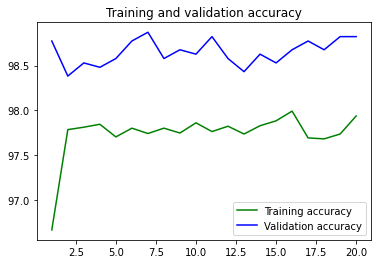

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(range(1,21), training_accs, 'g', label='Training accuracy')
plt.plot(range(1,21), val_accs, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

Loading a saved model which got better validation accuracy without overfitting

In [51]:
modelloaded = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
num_ftrs = modelloaded.classifier[6].in_features
modelloaded.fc = nn.Linear(num_ftrs, 10)
modelloaded.load_state_dict(torch.load(filepath+"Models/model_alex_epoch6.pth"))
modelloaded.eval()
modelloaded = modelloaded.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Test data Prediction

In [24]:
str(len(glob(filepath+'TestData/*/*.jpg')))

'2019'

Total number of test data : 2019


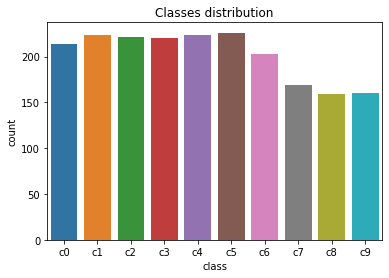

In [25]:
d = {"img" : [], "class" : []}
for c in classes:
    imgs = [img for img in os.listdir(os.path.join(filepath+"TestData",c)) if not img.startswith(".")]
    for img in imgs:
        d["img"].append(img)
        d["class"].append(c)
df = pd.DataFrame(d)
ax = sns.countplot(data=df,x="class")
ax.set(title="Classes distribution")
print("Total number of test data :",len(df))

In [26]:
testdata = datasets.ImageFolder(root = filepath+"TestData", transform = transform)
test_loader = torch.utils.data.DataLoader(dataset=testdata,
                                           batch_size=32,
                                           shuffle=True,
                                           drop_last=False,
                                           num_workers=2)


In [27]:
def true_pred(test_data,model):
    y_true = []
    y_pred = []
    n = len(test_data)
    sum = 0
    with torch.no_grad():
        for x,y in tqdm(test_data):
            x = x.to(device)
            pred = torch.argmax(model(x),dim=1)
            y_true.extend(list(np.array(y)))
            y_pred.extend(list(np.array(pred.cpu())))
    return y_true,y_pred

In [52]:
y_true,y_pred = true_pred(test_loader,modelloaded)

100%|██████████| 64/64 [00:16<00:00,  3.78it/s]


Performance Metrics

In [29]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)*100

81.87221396731054

In [31]:
precision = precision_score(y_true,y_pred,average='micro')
print('Precision: ', precision)

Precision:  0.8187221396731055


In [32]:
f1 = f1_score(y_true,y_pred,average='micro')
print('F1 score: ', f1)

F1 score:  0.8187221396731054


In [34]:
recallscore = recall_score(y_true,y_pred,average='micro')
print('Recall score: ', recallscore)

Recall score:  0.8187221396731055


In [35]:
from sklearn.metrics import classification_report
final_repo = classification_report(y_true, y_pred, zero_division=1,target_names = list(class_dict.values()))
print(final_repo)

                              precision    recall  f1-score   support

                safe driving       0.66      0.79      0.72       214
             texting - right       1.00      0.79      0.88       224
talking on the phone - right       0.99      0.96      0.97       221
              texting - left       0.89      0.97      0.93       220
 talking on the phone - left       0.90      0.86      0.88       223
         operating the radio       1.00      0.99      0.99       226
                    drinking       0.98      0.59      0.74       203
             reaching behind       0.88      0.96      0.92       169
             hair and makeup       0.46      0.74      0.56       159
        talking to passenger       0.53      0.42      0.47       160

                    accuracy                           0.82      2019
                   macro avg       0.83      0.81      0.81      2019
                weighted avg       0.85      0.82      0.82      2019



In [36]:
def topk_pred(test_data,model,k):
    y_true = []
    y_pred = []
    n = len(test_data)
    sum = 0
    with torch.no_grad():
        for x,y in tqdm(test_data):
            x = x.to(device)
            #print("\ntwo indexe", torch.topk(x, 2).indices)
            #pred = torch.argmax(model(x),dim=1)
            pred = torch.topk(model(x), k).indices
            y_true.extend(list(np.array(y)))
            y_pred.extend(list(np.array(pred.cpu())))
            #print(len(y_true), len(y_pred))
    positivecount = 0
    for i in range(len(y_true)):
      if y_true[i] in y_pred[i]:
        positivecount += 1

    return positivecount/len(y_true)

In [37]:
top2_acc = topk_pred(test_loader,modelloaded,2)

100%|██████████| 64/64 [00:15<00:00,  4.13it/s]


In [38]:
print("The accuracy of top 2 prediction for the model is ", top2_acc)

The accuracy of top 2 prediction for the model is  0.942545814759782


In [39]:
confusionMatrix = confusion_matrix(y_true,y_pred)


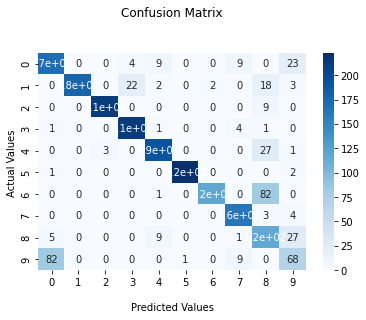

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

ax = sns.heatmap(confusionMatrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
#ax.xaxis.set_ticklabels(['False','True'])
#ax.yaxis.set_ticklabels(['False','True'])
plt.show()

In [47]:
files = np.random.choice(dataList[dataList['subject'].isin(['p012','p026'])]['img'].tolist(),9)

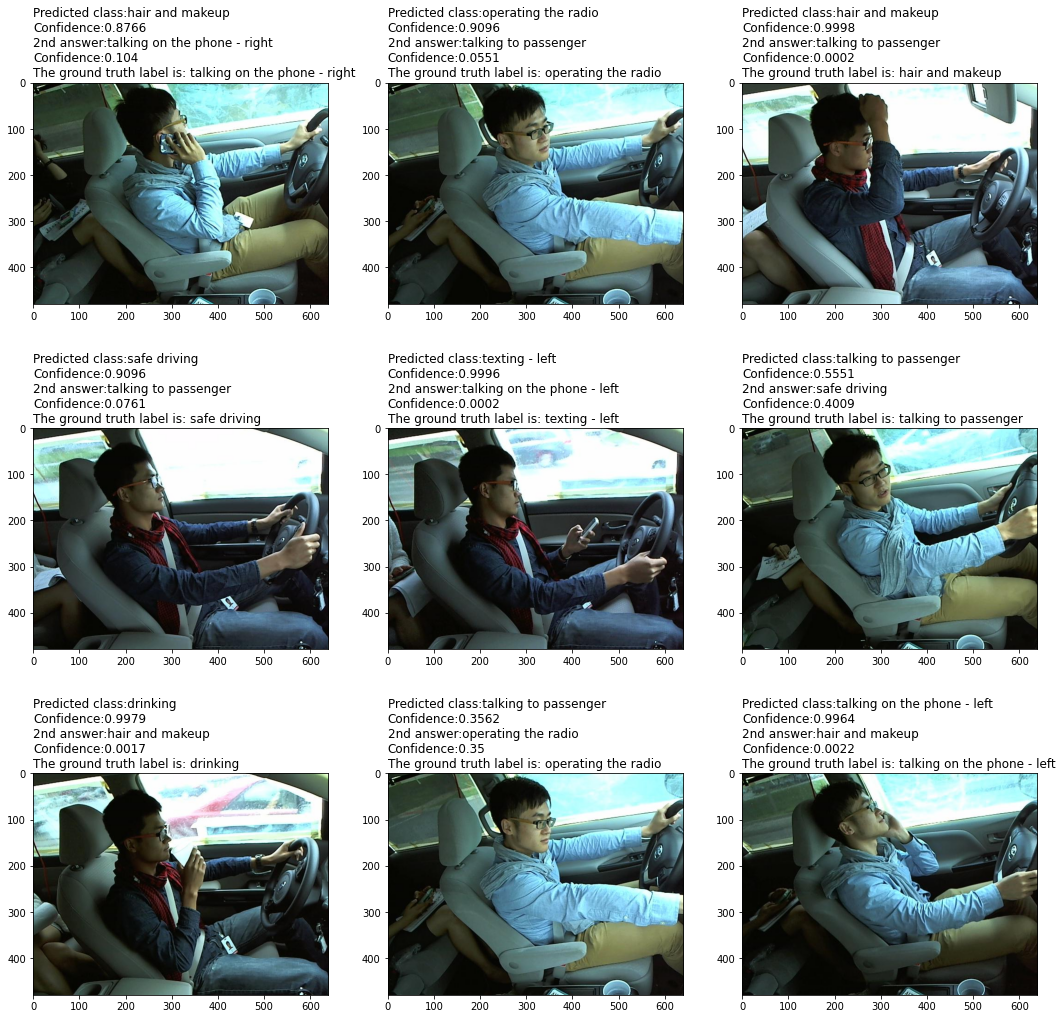

In [48]:
from pandas.io.parsers.readers import TextFileReader
plt.figure(figsize=(18,18))
text_list = []

for i in range(len(files)):
    plt.subplot(3,3,i+1)   
    img = cv2.imread(glob(filepath+'TestData/*/'+files[i])[0])
    img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_cvt)
    with PIL.Image.open(glob(filepath+'TestData/*/'+files[i])[0]) as im:
      im = transform(im)
      im = im.unsqueeze(0)
      output = modelloaded(im.cuda())
      proba = nn.Softmax(dim=1)(output)
      proba = [round(float(elem),4) for elem in proba[0]]
      proba2 = proba.copy()
      proba2[proba2.index(max(proba2))] = 0.
      text  = "Predicted class:"+class_dict[proba.index(max(proba))]+"\n"+"Confidence:"+str(max(proba))+"\n"+"2nd answer:"+class_dict[proba2.index(max(proba2))]+"\n"+"Confidence:"+str(max(proba2))+"\n"+"The ground truth label is: "+class_dict[int(dataList[dataList['img'] == files[i]]["classname"].iloc[0][1:])]
      text_list.append(text)
      

    plt.title(text, loc='left')



plt.show()

# Grad Came

In [43]:
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.1 MB 6.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.2-py3-none-any.whl size=32305 sha256=31426ddca0472604e955ecd475b32db9a611d2659565c5c49345929d95fba746
  Stored in directory: /root/.cache/pip/wheels/a0/9c/d6/980994b42f520eade90b6d5c7e2613dad62d50d2497820d208
Successfully built grad-cam


ref: https://jacobgil.github.io/pytorch-gradcam-book/introduction.html

In [44]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import torch

from torchvision import transforms

from PIL import Image

def gradcammap(modelloaded,file):
  target_layers = [modelloaded.features[-1]]
  #target_layers = modelloaded.classifier[6].out_features
  #print(target_layers)
  convert_tensor = transforms.ToTensor()
  img = Image.open(glob(filepath+'TestData/*/'+file)[0])

  input_tensor = convert_tensor(img).unsqueeze(0)

  cam = GradCAM(model=modelloaded, target_layers=target_layers, use_cuda=device)

  targets = [ClassifierOutputTarget(281)]

  # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
  grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

  grayscale_cam = grayscale_cam[0, :]
  visualization = show_cam_on_image(np.asarray(img,dtype="float32")/255, grayscale_cam, use_rgb=True)
  return visualization

In [49]:
img_vis_lst = []
for file in files:
  img_vis_lst.append(gradcammap(modelloaded,file))

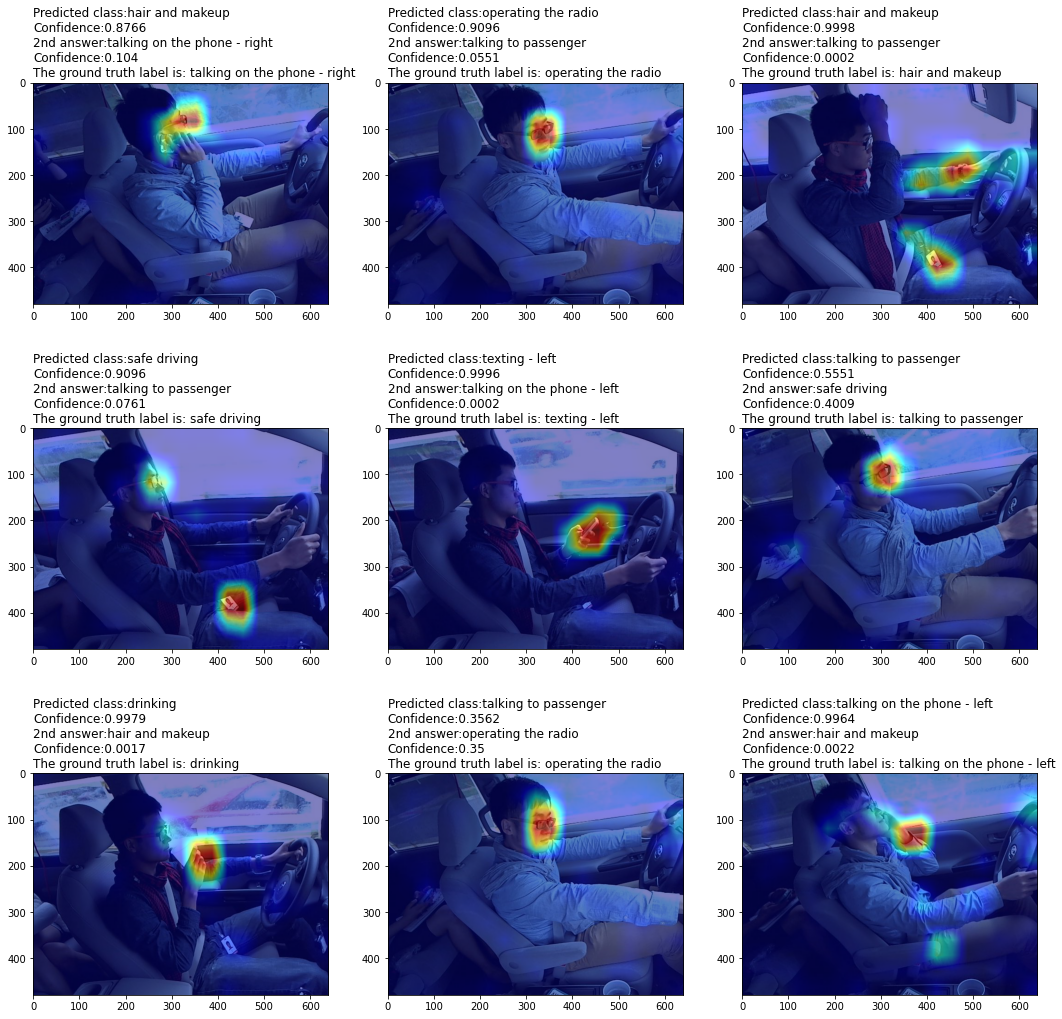

In [50]:
plt.figure(figsize=(18,18))

for i in range(len(img_vis_lst)):
    plt.subplot(3,3,i+1)   
    plt.imshow(img_vis_lst[i])
    plt.title(text_list[i], loc='left')